---
title: "Midterm 2"
jupyter: python3
author: "Paul C "
date: "10-04-2025"
format: 
    html:
        embed-resources: true
---


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Carga de dataset


In [2]:
# 1. CARGAR DATASET
print("="*70)
print("CLASIFICACIÓN DE CANCHAS - REGRESIÓN LOGÍSTICA")
print("="*70)

try:
    df = pd.read_csv('canchas.csv', sep=';', encoding='utf-8-sig')
except:
    df = pd.read_csv('canchas.csv', sep=';', encoding='latin-1')

df.columns = df.columns.str.strip().str.replace('ï»¿', '')
df = df.loc[:, df.columns != '']
df = df.loc[:, ~df.columns.str.match('^Unnamed')]

print(f"Total de registros: {len(df)}")

CLASIFICACIÓN DE CANCHAS - REGRESIÓN LOGÍSTICA
Total de registros: 147


## Variable objetivo


In [3]:
# 2. VARIABLE OBJETIVO
costo_col = 'Costo por uso de las instalaciones'
df[costo_col] = pd.to_numeric(df[costo_col], errors='coerce')
df['tiene_costo'] = (df[costo_col] > 0).astype(int)

print("\n" + "="*70)
print("DISTRIBUCIÓN DE CLASES")
print("="*70)
dist = df['tiene_costo'].value_counts().sort_index()
total = dist.sum()
print(f"Gratis (0):    {dist.get(0, 0):3d} canchas ({dist.get(0, 0)/total*100:5.2f}%)")
print(f"Con costo (1): {dist.get(1, 0):3d} canchas ({dist.get(1, 0)/total*100:5.2f}%)")
print(f"\nDesbalanceo de clases: {dist.get(0, 0)/dist.get(1, 0):.2f}:1")


DISTRIBUCIÓN DE CLASES
Gratis (0):    133 canchas (90.48%)
Con costo (1):  14 canchas ( 9.52%)

Desbalanceo de clases: 9.50:1


## Seleccion de features


In [4]:
# 3. SELECCIONAR FEATURES
features_map = {
    'zonal': None, 'provincia': None, 'canton': None, 'estado': None,
    'cubierta': None, 'propiedad': None, 'uso': None
}

for col in df.columns:
    col_norm = col.lower().replace('á', 'a').replace('é', 'e').replace('í', 'i').replace('ó', 'o').replace('ú', 'u')
    if 'zonal' in col_norm or 'coordinacion' in col_norm:
        features_map['zonal'] = col
    elif 'provincia' in col_norm:
        features_map['provincia'] = col
    elif 'canton' in col_norm:
        features_map['canton'] = col
    elif 'estado' in col_norm:
        features_map['estado'] = col
    elif 'cubierta' in col_norm or 'caracteristica' in col_norm:
        features_map['cubierta'] = col
    elif 'propiedad' in col_norm and 'tipo' in col_norm:
        features_map['propiedad'] = col
    elif 'uso' in col_norm and 'escenario' in col_norm:
        features_map['uso'] = col

features = [v for v in features_map.values() if v is not None]

print("\n" + "="*70)
print("FEATURES SELECCIONADAS")
print("="*70)
for i, feat in enumerate(features, 1):
    n_unique = df[feat].nunique()
    print(f"{i}. {feat}: {n_unique} categorías")


FEATURES SELECCIONADAS
1. Coordinación Zonal: 3 categorías
2. Provincia: 7 categorías
3. Cantón: 48 categorías
4. Estado: 4 categorías
5. Características de cubierta del escenario: 2 categorías
6. Tipo de propiedad: 2 categorías
7. Uso del escenario deportivo: 61 categorías


## Preparar datos


In [5]:
# 4. PREPARAR DATOS
datos_validos = df[df['tiene_costo'].notna()]
df_model = datos_validos[features + ['tiene_costo']].copy()

for col in features:
    df_model[col] = df_model[col].fillna('Desconocido')

df_model = df_model.drop_duplicates()
print(f"\nDatos finales: {len(df_model)} registros ({len(df_model)/len(df)*100:.1f}% del total)")



# 5. CODIFICAR
encoders = {}
for col in features:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    encoders[col] = le

X = df_model[features].values
y = df_model['tiene_costo'].values

# 6. SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n" + "="*70)
print("DIVISIÓN DE DATOS")
print("="*70)
print(f"Train: {len(X_train)} muestras (Gratis: {(y_train==0).sum()}, Con costo: {(y_train==1).sum()})")
print(f"Test:  {len(X_test)} muestras (Gratis: {(y_test==0).sum()}, Con costo: {(y_test==1).sum()})")



Datos finales: 122 registros (83.0% del total)

DIVISIÓN DE DATOS
Train: 97 muestras (Gratis: 86, Con costo: 11)
Test:  25 muestras (Gratis: 22, Con costo: 3)


## Pipeline


In [6]:
# 7. PIPELINE CON REGRESIÓN LOGÍSTICA
print("\n" + "="*70)
print("ENTRENANDO MODELO")
print("="*70)

pipe = Pipeline([
    ('escalado', StandardScaler()),
    ('logreg', LogisticRegression(
        max_iter=100000,
        random_state=42,
        class_weight='balanced'  # Maneja el desbalanceo de clases
    ))
])

print("Entrenando Regresión Logística con class_weight='balanced'...")
pipe.fit(X_train, y_train)
print("✓ Modelo entrenado exitosamente\n")


ENTRENANDO MODELO
Entrenando Regresión Logística con class_weight='balanced'...
✓ Modelo entrenado exitosamente



## Predicciones


In [7]:
# 8. PREDICCIONES
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)


## Evaluacion


In [8]:
# 9. EVALUACIÓN - TRAIN
print("="*70)
print("RESULTADOS - CONJUNTO DE ENTRENAMIENTO")
print("="*70)
acc_train = accuracy_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train, zero_division=0)
rec_train = recall_score(y_train, y_pred_train, zero_division=0)
f1_train = f1_score(y_train, y_pred_train, zero_division=0)

print(f"Accuracy:  {acc_train:.4f} ({acc_train*100:.2f}%)")
print(f"Precision: {prec_train:.4f} ({prec_train*100:.2f}%)")
print(f"Recall:    {rec_train:.4f} ({rec_train*100:.2f}%)")
print(f"F1-Score:  {f1_train:.4f} ({f1_train*100:.2f}%)")

RESULTADOS - CONJUNTO DE ENTRENAMIENTO
Accuracy:  0.6392 (63.92%)
Precision: 0.2000 (20.00%)
Recall:    0.7273 (72.73%)
F1-Score:  0.3137 (31.37%)


## Evaluacion


In [9]:
# 10. EVALUACIÓN - TEST
print("\n" + "="*70)
print("RESULTADOS - CONJUNTO DE PRUEBA")
print("="*70)
acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test, zero_division=0)
rec_test = recall_score(y_test, y_pred_test, zero_division=0)
f1_test = f1_score(y_test, y_pred_test, zero_division=0)


RESULTADOS - CONJUNTO DE PRUEBA


## Evaluacion del modelo


In [10]:
diferencia = abs(acc_train - acc_test)

## Visualizaciones


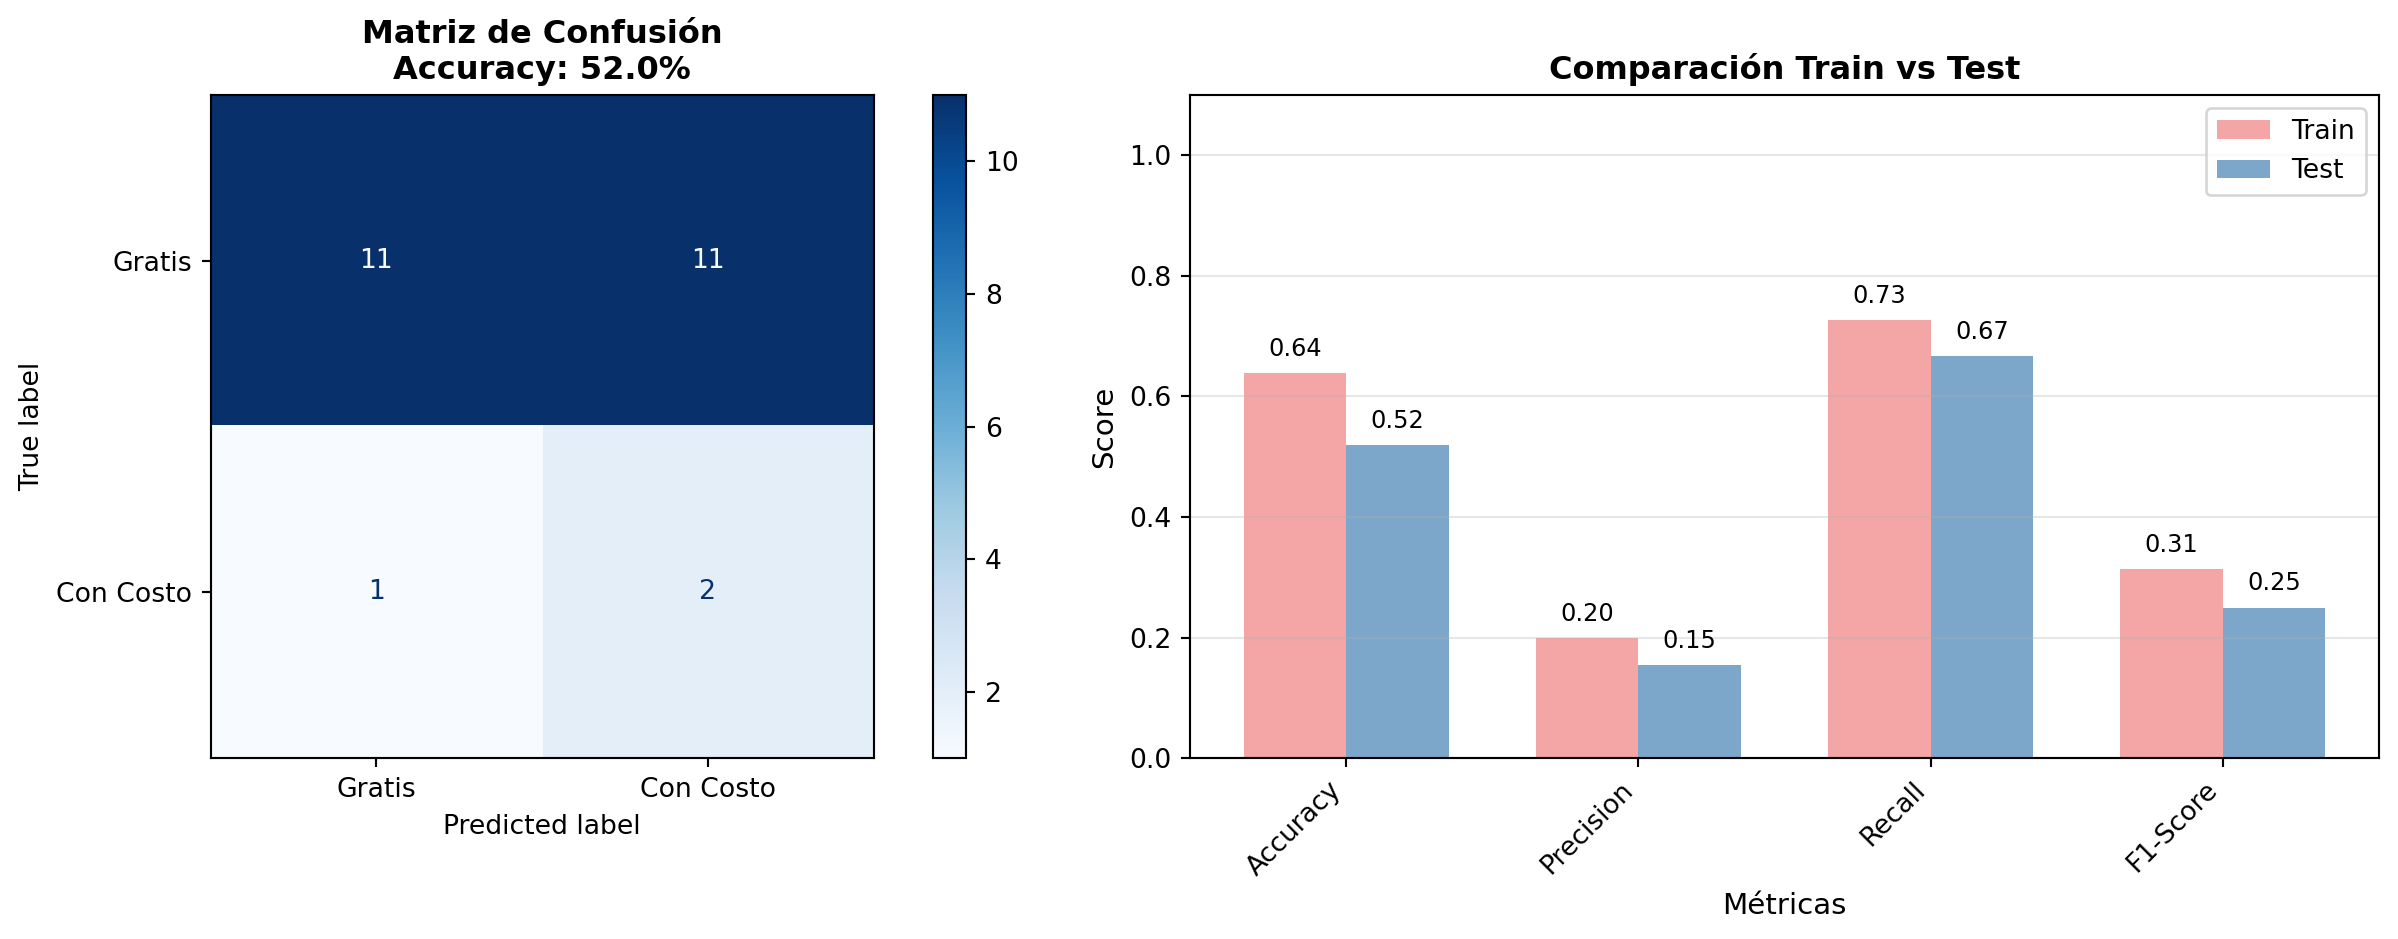

In [11]:
# 12. VISUALIZACIONES
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_test,
    display_labels=['Gratis', 'Con Costo'],
    cmap='Blues',
    ax=axes[0]
)
axes[0].set_title(f'Matriz de Confusión\nAccuracy: {acc_test*100:.1f}%', 
                 fontsize=12, fontweight='bold')

# Comparación de métricas Train vs Test
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
valores_train = [acc_train, prec_train, rec_train, f1_train]
valores_test = [acc_test, prec_test, rec_test, f1_test]

x = np.arange(len(metricas))
width = 0.35

axes[1].bar(x - width/2, valores_train, width, label='Train', color='lightcoral', alpha=0.7)
axes[1].bar(x + width/2, valores_test, width, label='Test', color='steelblue', alpha=0.7)
axes[1].set_xlabel('Métricas', fontsize=11)
axes[1].set_ylabel('Score', fontsize=11)
axes[1].set_title('Comparación Train vs Test', fontweight='bold', fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels(metricas, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1.1])

# Agregar valores en las barras
for i, v in enumerate(valores_train):
    axes[1].text(i - width/2, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=9)
for i, v in enumerate(valores_test):
    axes[1].text(i + width/2, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
